This notebook was created on December 2024. 


Its primary purpose is to generate and manipulate small road networks that can serve as inputs for tests.


In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random

print(f"""OSMnx version: {ox.__version__}""")

f"""NetworkX version: {nx.__version__}"""



OSMnx version: 1.2.3


'NetworkX version: 3.2.1'

### What is an OSMnx network?

Copied from [OSMnx 2.0.0 docs](https://osmnx.readthedocs.io/en/stable/getting-started.html#model-attributes): 

As a NetworkX MultiDiGraph object, it has top-level graph, nodes, and edges attributes. 
- The graph attribute dictionary must contain a “crs” key defining its coordinate reference system. 

- The nodes are identified by OSM ID and each must contain a data attribute dictionary that must have “x” and “y” keys defining its coordinates and a “street_count” key defining how many physical streets are incident to it. 

- The edges are identified by a 3-tuple of “u” (source node ID), “v” (target node ID), and “key” (to differentiate parallel edges), and each must contain a data attribute dictionary that must have an “osmid” key defining its OSM ID and a “length” key defining its length in meters.



To create a road network, one can make a NetworkX object with the properties above. 

In this notebook we take a different approach: we download a small road network and modify it as needed.

### Specify place

In [27]:
alameda = {
        "city": "Alameda",
        "county": "Alameda County",
        "state": "California",
        "country": "USA",
    }

### Download actual walking road network

In [28]:
G = ox.graph_from_place(alameda, network_type="walk")

type(G)


networkx.classes.multidigraph.MultiDiGraph

In [29]:
f"""Alameda city's walking road network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges"""

"Alameda city's walking road network has 7373 nodes and 21176 edges"

That's still too large for our purposes. Let's choose a subgraph

In [30]:
# Fix a seed to get reproducible results
random.seed(42)

# choose a random node 
ego_node = random.choice(list(G.nodes))

ego_node

5909483625

### Getting a subgraph

In [31]:
# Get the subgraph of G that contains the ego_node and up to 2 nodes away from it. Includes edges

subgraph = nx.ego_graph(G, ego_node, radius=2)

f"""Subgraph has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges"""

'Subgraph has 4 nodes and 6 edges'

### Here's a pretty picture

Ok, a picture

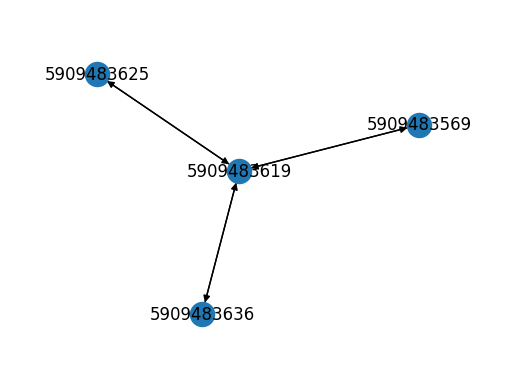

In [23]:
nx.draw_networkx(subgraph)

# Set margins for the axes so nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()


# notice that the ego_node is NOT the one in the center

### Save/load network as a graphml file

In [32]:
# This notebook is in the test_data folder because it makes logical 
# sense as it is used to create test_data. Plus, it simplifies the filepath

filepath = "subgraph.graphml"

ox.save_graphml(subgraph, filepath)



Did that work? Let's load it

In [33]:
subgraph_saved = ox.load_graphml(filepath)

# this function exists in nx 3.4.2:
# nx.graphs_equal(subgraph, subgraph_saved)

Since we can't use graphs_equal until we update nx, let's do some checks:

In [34]:
subgraph.nodes(data=True) == subgraph_saved.nodes(data=True)

True

In [35]:
list(subgraph.edges(data=True)) == list(subgraph_saved.edges(data=True))

True

### Yay!

Ok, sorry if it didn't work for you... but I'm celebrating because it works for me now :)

### Finally: please keep test_data clean :)

- If you end up using the graph in a test, give it a sensible name (not subgraph, like I did here)
- If you don't end up using the graph, please remove it:

In [36]:
from pathlib import Path

file_path = Path(filepath)
if file_path.exists():
    file_path.unlink()
    print(f"{file_path} has been removed.")
else:
    print(f"{file_path} does not exist.")

subgraph.graphml has been removed.
